In [164]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, HourLocator
import matplotlib as mpl

plt.style.use("dark_paper")
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

In [2]:
affluent = pd.read_hdf('averaged_daily.h5', key='affluent')
comfortable = pd.read_hdf('averaged_daily.h5', key='comfortable')
adversity = pd.read_hdf('averaged_daily.h5', key='adversity')
affluent0 = pd.read_hdf('averaged_daily.h5', key='affluent0')
comfortable0 = pd.read_hdf('averaged_daily.h5', key='comfortable0')
adversity0 = pd.read_hdf('averaged_daily.h5', key='adversity0')
dtemp = pd.read_hdf('temp.h5', 'data')
dailytemp = dtemp.resample('1D').mean()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


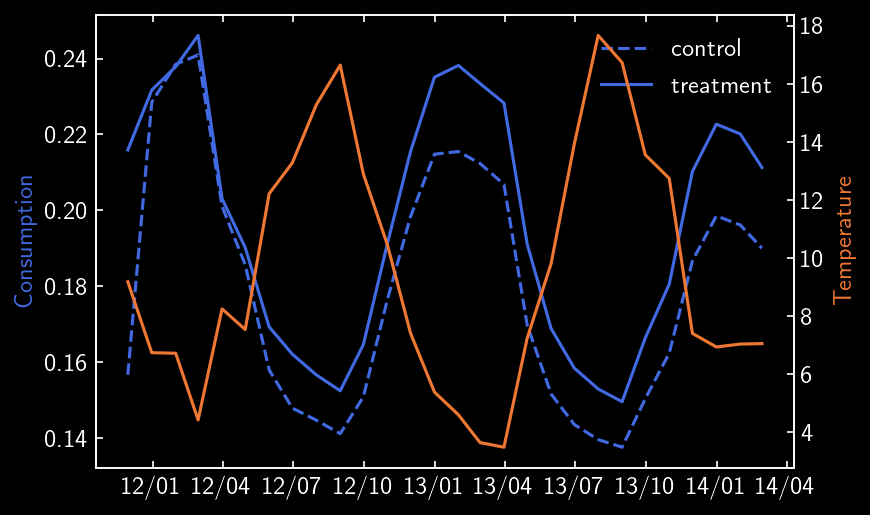

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
ax1 = ax.twinx()

ax.plot((.3*(affluent+comfortable+adversity)).resample('1M').mean(), c='C0', ls='--', label='control')
ax.plot((.3*(affluent0+comfortable0+adversity0)).resample('1M').mean(), c='C0', ls='-', label='treatment')
ax.legend()
ax.set_ylabel('Consumption', color='C0')
ax1.plot(dtemp[affluent.index].resample('1M').mean(), label='temperature', c='C3')
ax1.set_ylabel('Temperature', color='C3')
ax1.xaxis.set_major_formatter(DateFormatter('%y/%m'))
plt.show()

In [4]:
X = .3*(affluent+comfortable+adversity)
Y = dtemp[affluent.index]
print('Consumption and temperature correlation:', X.corr(Y))

Consumption and temperature correlation: -0.7865950437810019


In [13]:
def get_delta(group):
    treatment = pd.read_hdf('averaged_daily.h5', key=group)
    control = pd.read_hdf('averaged_daily.h5', key=group+'0')
    treat2013 = treatment[(treatment.index<'2014-01-01')&(treatment.index>'2012-12-31')].values
    treat2012 = treatment[(treatment.index<'2013-01-01')&(treatment.index>'2011-12-31')].values[:len(treat2013)]
    control2013 = control[(control.index<'2014-01-01')&(control.index>'2012-12-31')].values
    control2012 = control[(control.index<'2013-01-01')&(control.index>'2011-12-31')].values[:len(treat2013)]
    treatdiff = treat2012 - treat2013
    controldiff = control2012 - control2013
    return (treatdiff, controldiff)

# $\Delta$ T-test

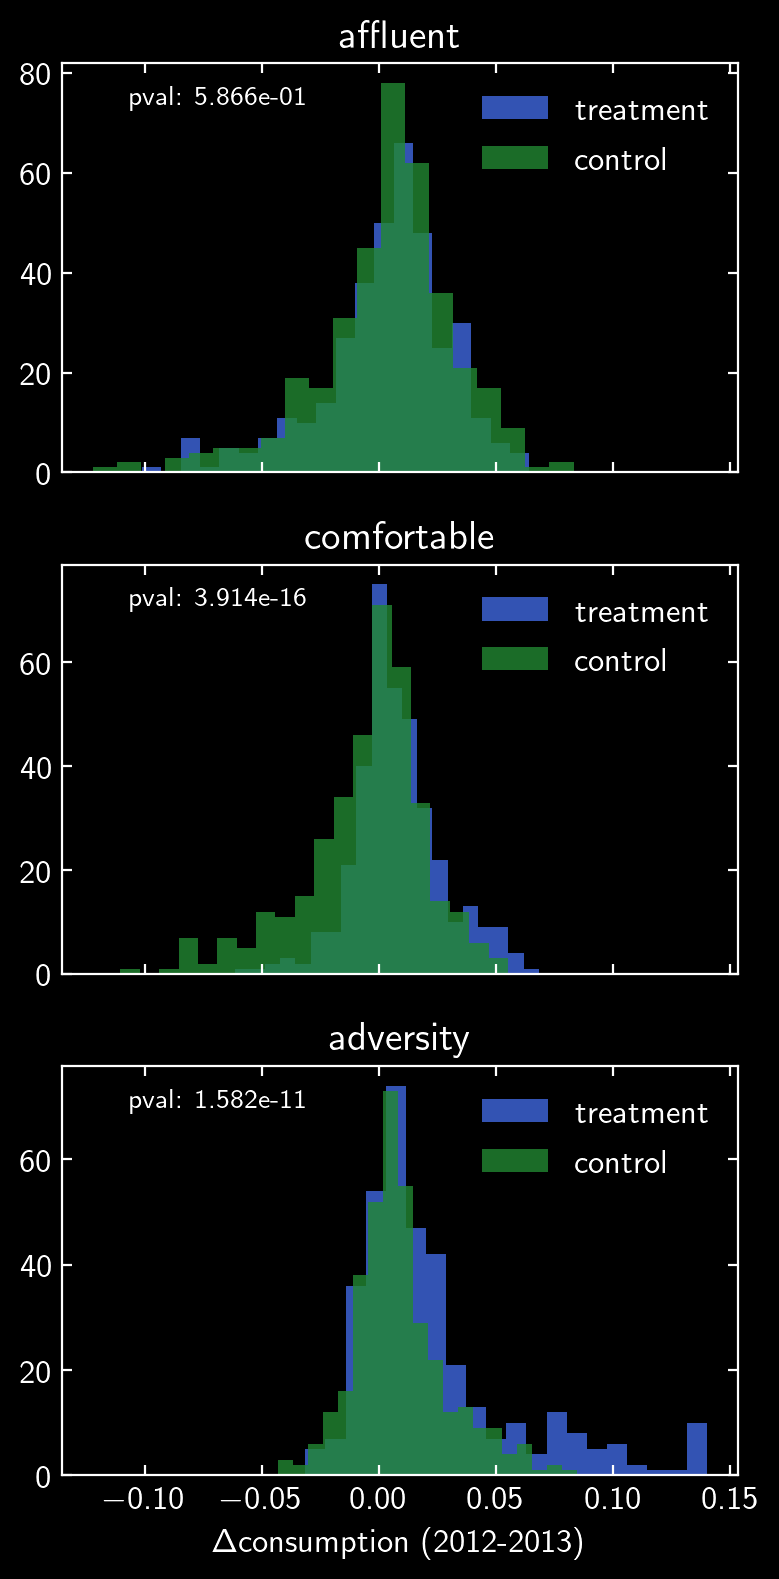

In [34]:
fig, axes = plt.subplots(3,1, figsize=(4,8), sharex=True,dpi=200)
for ax, group in  zip(axes.flatten(), ['affluent', 'comfortable', 'adversity']):
    (treatdiff, controldiff) = get_delta(group)
    ax.hist(treatdiff, alpha=.8, label='treatment', bins=20)
    ax.hist(controldiff, alpha=.8, label='control', bins=20)
    ax.set_title(group)
    ax.legend()
    pvalue = stats.ttest_ind(*get_delta(group), equal_var=False, alternative='greater').pvalue
    ax.text(0.1, 0.9, f'pval: {pvalue:.3e}', transform=ax.transAxes)
ax.set_xlabel(r'$\Delta$consumption (2012-2013)')

fig.tight_layout()

# T-test with and without normalization

In [368]:
def plot_year(group, year=2012, norm=None, normalize=True, ax=None, mean=False, alpha=.5):
    title = f'{group} - {year}'
    treatment = pd.read_hdf('averaged_daily.h5', key=group)
    treatment = treatment[(treatment.index<f"{year+1}-01-01")&(treatment.index>=f"{year}-01-01")]
    control = pd.read_hdf('averaged_daily.h5', key=group+'0')
    control = control[(control.index<f"{year+1}-01-01")&(control.index>=f"{year}-01-01")]
    if norm is None:
        norm = control.sum()/treatment.sum()
    if normalize:
        treatment *= norm
        title +=' normalized'
    pval = stats.ttest_ind(control.values, treatment.values, equal_var=False, alternative='greater').pvalue
    if ax is not None:
        plt.sca(ax)
    if mean:
        control.resample('15D').mean().plot(ax=ax, ls='--', c='C0', label='control', use_index=True)
        treatment.resample('15D').mean().plot(ax=ax, ls='--', c='C1', label='treatment', use_index=True)
    ax.xaxis.set_major_locator(MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter('%y/%m'))
    plt.plot(control, alpha=alpha, c='C0')
    plt.plot(treatment, alpha=alpha, c='C1')
    plt.title(title)
    plt.text(0.05, 0.1, f'pval: {pval:.3e}', transform=plt.gca().transAxes)
    return norm

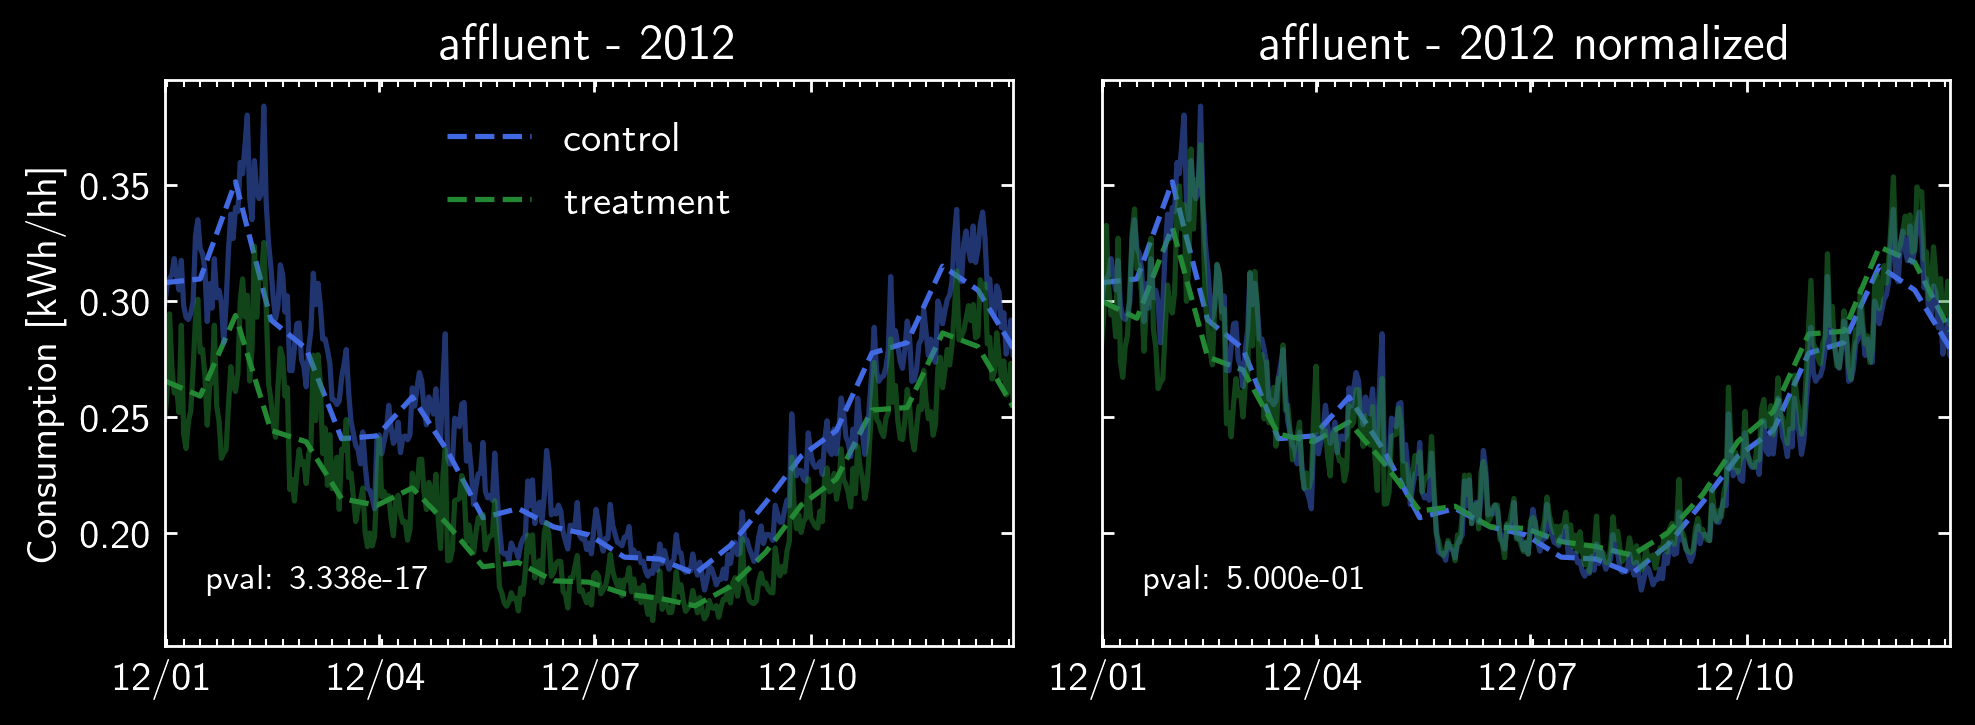

In [369]:
fig, [ax,ax1] = plt.subplots(1,2, figsize=(8,3), dpi=250, sharey=True)
norm = plot_year('affluent', year=2012, ax=ax, normalize=False, mean=True)
plot_year('affluent', year=2012, norm=norm, ax=ax1, normalize=True, mean=True)
ax.set_ylabel('Consumption [kWh/hh]')
ax.legend()
fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


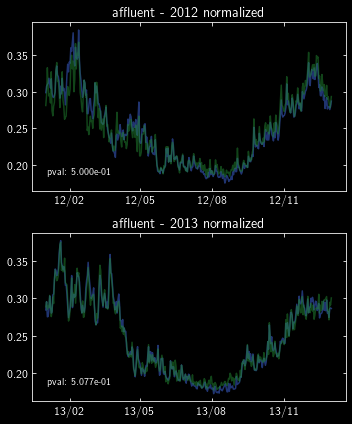

In [366]:
fig, [ax,ax1] = plt.subplots(2,1, figsize=(5,6))

norm = plot_year('affluent', year=2012, ax=ax, normalize=True)
plot_year('affluent', year=2013, norm=norm, ax=ax1, normalize=True)
fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


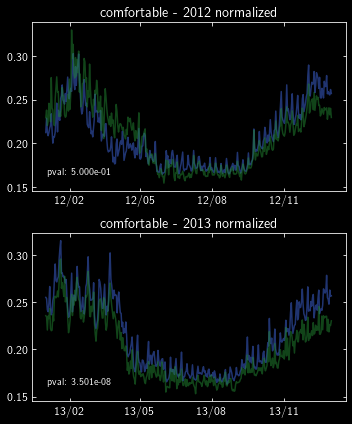

In [367]:
fig, [ax,ax1] = plt.subplots(2,1, figsize=(5,6))

norm = plot_year('comfortable', year=2012, ax=ax)
plot_year('comfortable', year=2013, norm=norm, ax=ax1)
fig.tight_layout()

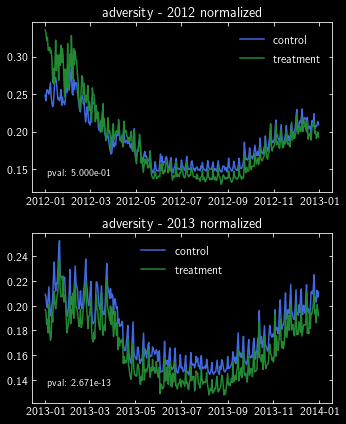

In [109]:
fig, [ax,ax1] = plt.subplots(2,1, figsize=(5,6))

norm = plot_year('adversity', year=2012, ax=ax)
plot_year('adversity', year=2013, norm=norm, ax=ax1)
fig.tight_layout()

# Look at group consumption at different hours
check the diff
check the integrated

In [213]:
affluent = pd.read_hdf('averaged_hourly.h5', key='affluent')
comfortable = pd.read_hdf('averaged_hourly.h5', key='comfortable')
adversity = pd.read_hdf('averaged_hourly.h5', key='adversity')
affluent0 = pd.read_hdf('averaged_hourly.h5', key='affluent0')
comfortable0 = pd.read_hdf('averaged_hourly.h5', key='comfortable0')
adversity0 = pd.read_hdf('averaged_hourly.h5', key='adversity0')
tar = pd.read_csv('data/Tariffs.csv')
tar.index = pd.to_datetime(tar['TariffDateTime'])
tar = tar['Tariff']
tar = tar.replace({"Low":0, "Normal":1, "High":2}).astype('int16')
tar_h = tar.groupby([tar.index.year, tar.index.month, tar.index.day, tar.index.hour]).mean()
tar_h.index = pd.to_datetime(['-'.join(map(str,x)) for x in tar_h.index], format="%Y-%m-%d-%H")

In [292]:
def get_pval(group):
    pvals_h = []
    for i in range(24):
        data = pd.read_hdf('averaged_hourly.h5', key=group)
        normal = data[tar_h.index[tar_h==1]]
        normal = normal[normal.index.hour==i]
        high = data[tar_h.index[tar_h==2]]
        high = high[high.index.hour==i]
        pvals_h.append(stats.ttest_ind(high.values, normal.values, equal_var=False, alternative='less').pvalue)
    return pvals_h

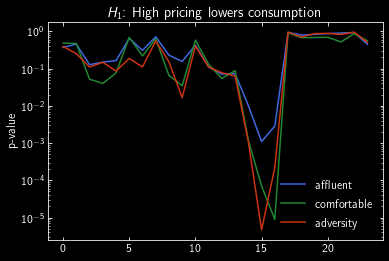

In [293]:
for name in ['affluent', 'comfortable', 'adversity']:
    plt.plot(get_pval(name), label=name)
plt.yscale('log')
plt.ylabel('p-value')
plt.legend(loc='lower right')
plt.title(r'$H_1$: High pricing lowers consumption ')
plt.show()

In [328]:
def get_high_normal(data, i):
        normal = data[tar_h.index[tar_h==1]]
        normal = normal[normal.index.hour==i]
        high = data[tar_h.index[tar_h==2]]
        high = high[high.index.hour==i]
        return  high, normal
    
def get_pval_diffs(group):
    pvals_h = []
    for i in range(24):
        data = pd.read_hdf('averaged_hourly.h5', key=group)
        data0 = pd.read_hdf('averaged_hourly.h5', key=group+'0')
        high, normal = get_high_normal(data, i)
        high0, normal0 = get_high_normal(data0, i)
        deltah = high - high0
        deltan = normal - normal0
        pvals_h.append(stats.ttest_ind(deltah.values, deltan.values, equal_var=False, alternative='less').pvalue)
        # assumes linear scaling
    return pvals_h

In [333]:
def get_pval_overall(group):
    h = []
    n = []
    h0= []
    n0= []
    for i in range(24):
        data = pd.read_hdf('averaged_hourly.h5', key=group)
        data0 = pd.read_hdf('averaged_hourly.h5', key=group+'0')
        high, normal = get_high_normal(data, i)
        high0, normal0 = get_high_normal(data0, i)
        h.append(high.mean())
        h0.append(high0.mean())
        n.append(normal.mean())
        n0.append(normal0.mean())  
    delta_control = np.subtract(h0,n0)
    delta_treatment = np.subtract(h,n)
    return stats.ttest_ind(delta_control, delta_treatment, equal_var=False, alternative='greater')

In [340]:
for name in ['affluent', 'comfortable', 'adversity']:
    print(f'{name:<15s} pvalue: {get_pval_overall(name).pvalue:.2e}')

affluent        pvalue: 5.46e-03
comfortable     pvalue: 1.86e-03
adversity       pvalue: 2.16e-03


In [329]:
# Learn from the control group to predict what the high hour looks like exactly. Not done with this analysis
# for now need to compare the difference in high time consumption vs normal for both control and treatment
# Consumption is higher at high hours for both but is there a difference in how high.
# Using nn to get the function P(X_high |X_normal) and compare 

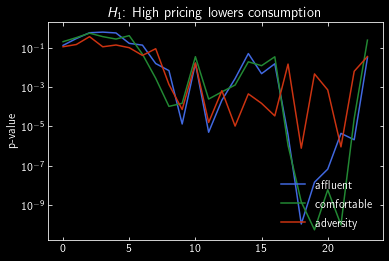

In [330]:
for name in ['affluent', 'comfortable', 'adversity']:
    plt.plot(get_pval_diffs(name), label=name)
plt.yscale('log')
plt.ylabel('p-value')
plt.legend(loc='lower right')
plt.title(r'$H_1$: High pricing lowers consumption ')
plt.show()

### hourly but normalized
Are high hours actually hours that are higher than they're supposed to be? Seems like it from mean consumption. Redo the test but with high_control vs high_treatment (as opposed to high_treatmeant vs normal_treatment.)

In [390]:
def plot_hourly(group, ax=None, tariff=None, ls='-', c=None, alpha=1):
    if ax is not None: plt.sca(ax)
    data = pd.read_hdf('averaged_hourly.h5', key=group)
    if tariff is not None:
        data = data[tar_h.index[tar_h==tariff]]
    y = data.groupby(data.index.hour).mean()
    std = data.groupby(data.index.hour).std()
    yerr = std/np.sqrt(data.groupby(data.index.to_series().dt.hour).count())
    x = np.arange(24)
    plt.errorbar(x, y, yerr, fmt='o-', label=group, ls=ls, color=c,alpha=alpha, ms=2)

In [391]:
ticks = np.arange(1,25,4)
ticklabels=[]
for i in ticks:
    q = 'AM'
    if i//12>0:
        q = 'PM'
    ticklabels.append(f'{i - (i//12)*12:02d}{q}')
print(ticks, ticklabels)

[ 1  5  9 13 17 21] ['01AM', '05AM', '09AM', '01PM', '05PM', '09PM']


AttributeError: module 'matplotlib.pyplot' has no attribute 'get_legend_handles_labels'

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=250, sharey=True)
plot_hourly('affluent', tariff=2,c='C0',alpha=.5)
plot_hourly('comfortable', tariff=2,c='C1',alpha=.5)
plot_hourly('adversity', tariff=2,c='C2',alpha=.5)
plt.legend()
handles, labels = ax.get_legend_handles_labels()
handles += [Line2D([0], [0], color='C4', lw=1, label='High', alpha=.5)]
handles += [Line2D([0], [0], color='C4', lw=1, label='Normal', ls='--')]
plot_hourly('affluent', tariff=1, ls='--',c='C0')
plot_hourly('comfortable', tariff=1, ls='--',c='C1')
plot_hourly('adversity', tariff=1, ls='--',c='C2')
plt.title('Treatment Group Normal and High Hour')
plt.xticks(ticks, ticklabels)
plt.legend(handles=handles, loc='upper left')
plt.show()

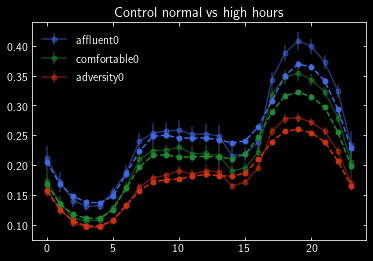

In [316]:
# Control normal vs high hours
fig, [ax,ax1] = plt.subplots(1,2, figsize=(8,3), dpi=250, sharey=True)
plot_hourly('affluent0', tariff=2,c='C0',alpha=.5)
plot_hourly('comfortable0', tariff=2,c='C1',alpha=.5)
plot_hourly('adversity0', tariff=2,c='C2',alpha=.5)
plt.legend()
plot_hourly('affluent0', tariff=1, ls='--',c='C0')
plot_hourly('comfortable0', tariff=1, ls='--',c='C1')
plot_hourly('adversity0', tariff=1, ls='--',c='C2')
plt.title('Control group Normal and High price')
plt.show()

In [ ]:
# Control high hours consumption is higher. Is there more consumption during high hours? 
# Compare consumption in high hours for both
# Compare consumption in regular hours for both

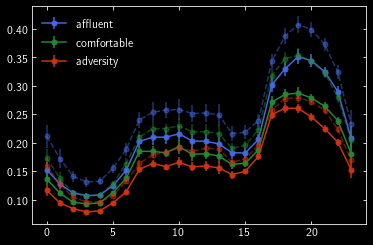

This plot shows a huge difference most of which would be gone if we account for the rescaling effect.


In [312]:
plot_hourly('affluent', tariff=2,c='C0')
plot_hourly('comfortable', tariff=2,c='C1')
plot_hourly('adversity', tariff=2,c='C2')
plt.legend()
plot_hourly('affluent0', tariff=2, ls='--',c='C0',alpha=.5)
plot_hourly('comfortable0', tariff=2, ls='--',c='C1',alpha=.5)
plot_hourly('adversity0', tariff=2, ls='--',c='C2',alpha=.5)
plt.show()
print('This plot shows a huge difference most of which would be gone if we account for the rescaling effect.')

## ML
Use rescaling to compare treat/control in 2013.
Use the ML model to predict 2013 data to avoid rescaling.